# Using resting-state Hemodynamic Response Function to simulate BOLD response in TVB

In this demo, we show how to use the resting-state Hemodynamic Response Function (rsHRF) obtained for the connectome, to simulate the BOLD response in TVB. The obtained rsHRF is more specific to the brain being modelled, and hence, is a positive step in the direction of obtaining individual specificity. For more information regarding obtaining connectome specific rsHRF, visit: https://www.nitrc.org/projects/rshrf


In [1]:
# Importing the relevant libraries
import os
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")

In [2]:
# The following two steps are required so that python does not search for tvb. imports in the installed version
path = os.getcwd() + "/tvb-root/scientific_library"
sys.path.insert(0, path)

from tvb.datatypes import equations
from tvb.simulator import monitors

For comparision we shall demonstrate 3 different monitors:
   1. bold_default: This corresponds to the default BOLD monitor (which uses the FirstOrderVolterra kernel
      for the Hemodynamic Response Function
   2. bold_rsHRF_fromFile: This corresponds to the BOLD monitor using the RestingStateHRF kernel, it reads
      the rsHRF as an input from a file and upsamples it to the monitor's sampling rate
   3. bold_rsHRF_roiTS: This also corresponds to the BOLD monitor using the restingStateHRF kernel, it reads
      the region-wise (as per the connectome being used) emperical BOLD time-series, and uses the functionality
      of the rsHRF-toolbox (http://bids-apps.neuroimaging.io/rsHRF/) to obtain the HRF. It also upsamples it
      to the monitor's sampling rate

## Default BOLD Monitor

In [3]:
bold_default = monitors.Bold()
bold_default.configure()
bold_default

,value
Type,Bold
gid,UUID('4e159681-37d3-4942-85f7-5eec20846067')
hrf_kernel,FirstOrderVolterra gid: 06122be5-ee59-4975-a94b-a35f4c3b90c4
hrf_length,20000.0
period,2000.0
title,Bold gid: 4e159681-37d3-4942-85f7-5eec20846067
variables_of_interest,None


In general, the sampling period of a monitor is in milliseconds and must be an integral multiple of the integration-step size used in a simulation.

Therefore, monitors need to know the integration time step (dt) because some data reduction mechanims (eg, downsampling to the monitor's sampling period) depend on it. An easy way to achieve this is:

In [4]:
bold_default.dt = 2**-4 # Default value used in the scripts found at tvb/simulator/demos

### HRF Function

In [5]:
bold_default.compute_hrf()
hrf_default  = bold_default.hemodynamic_response_function
print("Shape of the hrf is: ", hrf_default.shape)

Shape of the hrf is:  (1, 5000)


The shape of the hrf is 1x5000, where 5000 corresponds to the dimension along signal's x-axis. Hence, we are using the same signal for the BOLD simulation throughout the connectome, and across different connectomes. This reduces the subject level, and region level specificity of our model.

### Plotting the Kernel
By default, the method compute_hrf gives the reflected version of the HRF. The product between this reflected HRF and the monitor's neural activity history (convolution) yields the BOLD signal. In python the indexing [::-1] will give the HRF kernel as often seen in scientific publications.

The above behavior carries over to the way rsHRF is dealt. 

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


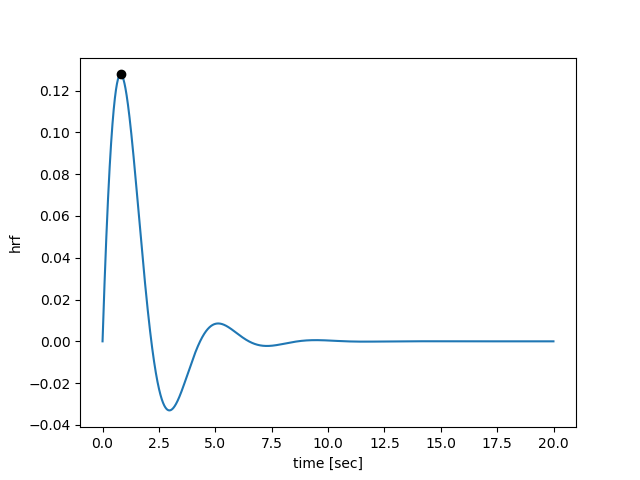

In [6]:
# plot the kernel
%pylab nbagg
plt.plot(bold_default._stock_time, hrf_default.T[::-1]); 
plt.ylabel('hrf');
plt.xlabel('time [sec]')
# plot the maximum
plt.plot(bold_default._stock_time[hrf_default.T[::-1].argmax()], hrf_default.T[::-1].max(), 'ko')

## BOLD Monitor With Resting-State HRF (from file)

In [8]:
bold_rsHRF_fromFile = monitors.Bold(hrf_kernel = equations.RestingStateHRF(rsHRF_filename = "./Input/dummy_rsHRF.txt"))
bold_rsHRF_fromFile.configure()
bold_rsHRF_fromFile

,value
Type,Bold
gid,UUID('89223f42-2c54-44b3-bdd8-eb5db718fd90')
hrf_kernel,RestingStateHRF gid: d8dd420a-1f8d-4490-92a1-69a88bbf76c4
hrf_length,20000.0
period,2000.0
title,Bold gid: 89223f42-2c54-44b3-bdd8-eb5db718fd90
variables_of_interest,None


### Input File
We have provided a dummy-input in the Input folder (dummy_rsHRF.txt). However, for the purpose of present demonstartion, we have merely used the downsampled HRF as obtained from the FirstOrderVolterra Kernel. The same in taken as input from the file.

### HRF Function

In [9]:
bold_rsHRF_fromFile.dt = 2**-4 # Default value used in the scripts found at tvb/simulator/demos
bold_rsHRF_fromFile.compute_hrf()
hrf_fromFile  = bold_rsHRF_fromFile.hemodynamic_response_function
print("Shape of the hrf is: ", hrf_fromFile.shape)

Shape of the hrf is:  (74, 5000)


The shape of the hrf is 74x5000, where 74 corresponds to the number of regions defined in our connectome. Hence, this allows us to use a specific HRF for each region for its corresponding BOLD simulations. This increases the specificity of the model.

### Plotting the Kernel

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


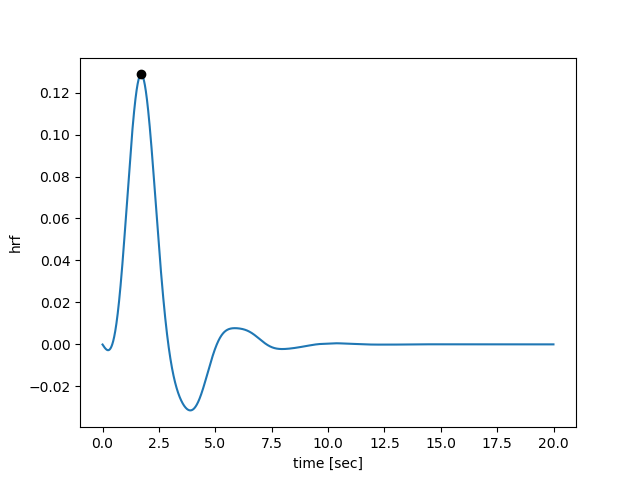

In [19]:
# plot the kernel
%pylab nbagg
plt.plot(bold_rsHRF_fromFile._stock_time, hrf_fromFile[0].T[::-1]); 
plt.ylabel('hrf');
plt.xlabel('time [sec]')
plt.plot(bold_rsHRF_fromFile._stock_time[hrf_fromFile[0][::-1].argmax()], hrf_fromFile[0][::-1].max(), 'ko')

Even when in theory we have used the same HRF signals for both the above cases, we can see slight differences between them primarily due to resampling.

## BOLD Monitor With Resting-State HRF (obtaining HRF from ROI Time-Series)

First we shall see the ROI time-series (empirical BOLD response) through which we shall obtain the HRF kernel.
The input for the same has been provided in the Input folder as ROIts.txt.  

In [11]:
roiTimeSeries = np.loadtxt("./Input/ROIts.txt")
print("Shape of the BOLD time-series: ", roiTimeSeries.shape)

Shape of the BOLD time-series:  (180, 68)


The shape of the input is 180x68, where 68 corresponds to the number of regions in the connectome, and 180 corresponds to the length of the signal.

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


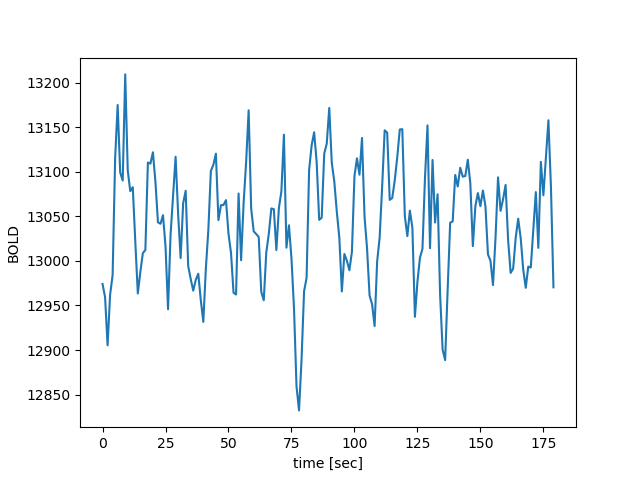

Text(0.5, 0, 'time [sec]')

In [12]:
# plotting the time-series corresponding to the first-region
%pylab nbagg
plt.plot(roiTimeSeries.T[0])
plt.ylabel('BOLD');
plt.xlabel('time [sec]')

The 2 Dimensional numpy-array is provided as the input to the RestingStateHRF.
Along with it, we also specify the HRF_length and TR which refer to the length of the HRF (in seconds) and the BOLD repetition time respectively. These are required to obtain the HRF from the BOLD time-series.

In [14]:
bold_rsHRF_roiTS = monitors.Bold(hrf_kernel = equations.RestingStateHRF(roiTS = roiTimeSeries, HRF_length = 24.0, TR = 2.100))
bold_rsHRF_roiTS.configure()
bold_rsHRF_roiTS

,value
Type,Bold
gid,UUID('b28f6839-a9e7-4946-91c9-9acc2c78cbbc')
hrf_kernel,RestingStateHRF gid: be33a4f2-76b8-445b-b669-bc7e7921e5bb
hrf_length,20000.0
period,2000.0
title,Bold gid: b28f6839-a9e7-4946-91c9-9acc2c78cbbc
variables_of_interest,None


### HRF Function

In [15]:
# let it run
bold_rsHRF_roiTS.dt = 2**-4 # Default value used in the scripts found at tvb/simulator/demos
bold_rsHRF_roiTS.compute_hrf()
hrf_roiTS  = bold_rsHRF_roiTS.hemodynamic_response_function
print("Shape of the hrf is: ", hrf_roiTS.shape)

Shape of the hrf is:  (68, 5000)


The above cell takes a small-while to run as it is computationally heavier than the previous methods in obtaining the HRF from the BOLD time-series (individually for each region in the connectome, the reason for the shape of hrf being 68x5000). 
There are several parameters which can be varied in the above computation, for more information about the same visit: http://bids-apps.neuroimaging.io/rsHRF/, and refer to the docs of the RestingStateHRF Kernel.
Here, for the purpose of our demonstration we proceed with the default parameters unless explicitly mentioned.

### Plotting the Kernel

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


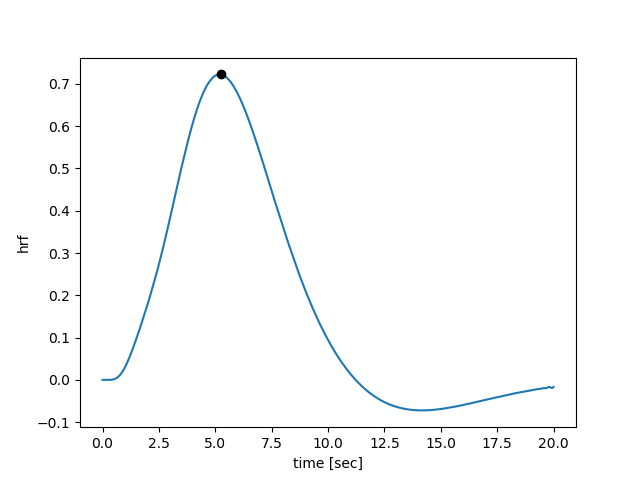

In [18]:
# plot the kernel
%pylab nbagg
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[0].T[::-1]);
plt.ylabel('hrf');
plt.xlabel('time [sec]')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[0][::-1].argmax()], hrf_roiTS[0][::-1].max(), 'ko')

### Plotting HRF For Multiple Regions

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


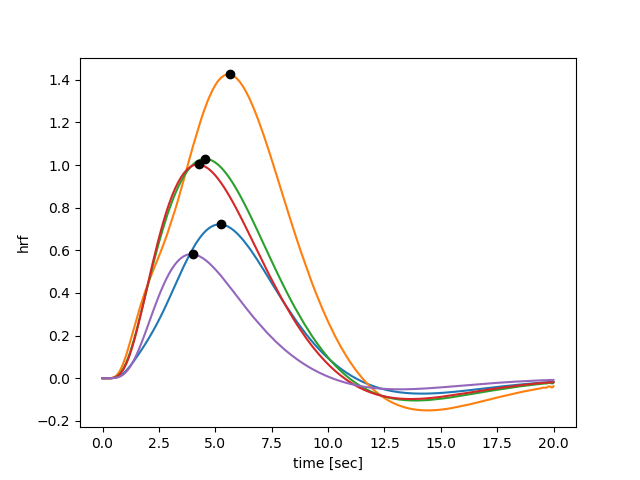

In [17]:
# plot the kernel
%pylab nbagg
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[0].T[::-1]);
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[1].T[::-1]);
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[2].T[::-1]);
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[3].T[::-1]);
plt.plot(bold_rsHRF_roiTS._stock_time, hrf_roiTS[4].T[::-1]);
plt.ylabel('hrf');
plt.xlabel('time [sec]')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[0][::-1].argmax()], hrf_roiTS[0][::-1].max(), 'ko')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[1][::-1].argmax()], hrf_roiTS[1][::-1].max(), 'ko')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[2][::-1].argmax()], hrf_roiTS[2][::-1].max(), 'ko')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[3][::-1].argmax()], hrf_roiTS[3][::-1].max(), 'ko')
plt.plot(bold_rsHRF_roiTS._stock_time[hrf_roiTS[4][::-1].argmax()], hrf_roiTS[4][::-1].max(), 'ko')

Here, we have plotted the obtained HRF for regions 0 to 4. As we can see the basic structure remains the same, but there are various significant differences.
Although relative magnitude is not something of our concern (as that shall get neutralized on normalizing the BOLD response from each region - a norm in BOLD fMRI analysis), the difference in their shapes (for example: the shift of the peak) is what accounts for higher specificity and accuracy of the BOLD simulations. This would otherwise get lost if we consider a constant HRF.

## References

> Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide,
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013)
    The Virtual Brain: a simulator of primate brain network dynamics.
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010)

> Guo-Rong Wu, Daniele Marinazzo. “Retrieving the Hemodynamic Response Function in resting state fMRI: methodology and applications.” PeerJ PrePrints, 2015.